# TP1 - Analyse des données financières

**Cours**: IFT599 / IFT799

**Projet**: TP1 — Analyse des transactions et détection de fraude

**Etudiants**: 
* Al sadick ismail altoum 
* Ousmane Ali Brahim 



## 0. Imports et configuration

In [1]:
# Bibliothèques principales
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Prétraitement et ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# dimension reduction / visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
# association rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules,apriori
from collections import Counter
from prefixspan import PrefixSpan
import networkx as nx
# warnings
import warnings
warnings.filterwarnings('ignore')

print('Imports OK')

Imports OK


## 1. Préparation des donnees 

### 1.1 Chargement des données

In [2]:
# Chargement des fichiers de données
def load_data():

      """Charge tous les fichiers de données nécessaires"""
      try:
        # Chargement des données principales
        transactions = pd.read_csv('transactions_data.csv')
        cards = pd.read_csv('cards_data.csv')
        users = pd.read_csv('users_data.csv')

        # Chargement des fichiers JSON
        with open('mcc_codes.json', 'r') as f:
            mcc_codes = json.load(f)
        mcc_df = pd.DataFrame.from_dict(mcc_codes, orient='index').reset_index()
        mcc_df.columns = ['mcc_code', 'mcc_description']

        with open('train_fraud_labels.json', 'r') as f:
            fraud_labels = json.load(f)
            fraud_labels=fraud_labels["target"]

        fraud_labels = pd.DataFrame(list(fraud_labels.items()),
                           columns=['transaction_id', 'is_fraud'])

        print("✅ Données chargées avec succès")
        print(f"Transactions: {transactions.shape}")
        print(f"Cartes: {cards.shape}")
        print(f"Users: {users.shape}")
        print(f"Codes MCC: {len(mcc_codes)} catégories")
        print(f"Labels fraude: {len(fraud_labels)} transactions")

        return transactions, cards, users, mcc_df, fraud_labels

      except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        return None, None, None, None, None

# Exécution du chargement
transactions, cards, users, mcc_codes, fraud_labels = load_data()


✅ Données chargées avec succès
Transactions: (2554758, 12)
Cartes: (6146, 13)
Users: (2000, 14)
Codes MCC: 109 catégories
Labels fraude: 8914963 transactions


## 1.2.1 premières inspections

In [3]:
def quick_explore(df, n=5):
    print("=== Aperçu des données ===")
    print(df.head(n))

    print("\n=== Dimensions ===")
    if isinstance(df, pd.DataFrame):
        print(f"Lignes: {df.shape[0]}, Colonnes: {df.shape[1]}")
    elif isinstance(df, pd.Series):
        print(f"Lignes: {df.shape[0]}, Colonnes: 1")

    print("\n=== Types de colonnes ===")
    if isinstance(df, pd.DataFrame):
        print(df.dtypes)
    else:  # Series
        print(df.dtype)

    print("\n=== Valeurs manquantes ===")
    print(df.isnull().sum())

In [4]:
quick_explore(transactions)

=== Aperçu des données ===
         id                 date  client_id  card_id   amount  \
0  20604847  2018-01-01 00:03:00        316     5857   $90.72   
1  20604849  2018-01-01 00:05:00       1954     4879   $69.21   
2  20604850  2018-01-01 00:06:00       1684     2723   $27.19   
3  20604851  2018-01-01 00:07:00        335      353  $363.62   
4  20604852  2018-01-01 00:08:00       1919     1215   $57.05   

             use_chip  merchant_id merchant_city merchant_state      zip  \
0    Chip Transaction        20561       Houston             TX  77048.0   
1    Chip Transaction        58192      La Habra             CA  90631.0   
2  Online Transaction        39021        ONLINE            NaN      NaN   
3    Chip Transaction        42636    Hallandale             FL  33009.0   
4    Chip Transaction        87819         Miami             FL  33142.0   

    mcc errors  
0  5912    NaN  
1  4900    NaN  
2  4784    NaN  
3  7802    NaN  
4  5812    NaN  

=== Dimensions ===
Lig

In [5]:
quick_explore(cards)


=== Aperçu des données ===
     id  client_id  card_brand        card_type       card_number  expires  \
0  4524        825        Visa            Debit  4344676511950444  12/2022   
1  2731        825        Visa            Debit  4956965974959986  12/2020   
2  3701        825        Visa            Debit  4582313478255491  02/2024   
3    42        825        Visa           Credit  4879494103069057  08/2024   
4  4659        825  Mastercard  Debit (Prepaid)  5722874738736011  03/2009   

   cvv has_chip  num_cards_issued credit_limit acct_open_date  \
0  623      YES                 2       $24295        09/2002   
1  393      YES                 2       $21968        04/2014   
2  719      YES                 2       $46414        07/2003   
3  693       NO                 1       $12400        01/2003   
4   75      YES                 1          $28        09/2008   

   year_pin_last_changed card_on_dark_web  
0                   2008               No  
1                   2014 

In [6]:
quick_explore(users)


=== Aperçu des données ===
     id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   

                    address  latitude  longitude per_capita_income  \
0             462 Rose Lane     34.15    -117.76            $29278   
1    3606 Federal Boulevard     40.76     -73.74            $37891   
2           766 Third Drive     34.02    -117.89            $22681   
3          3 Madison Street     40.71     -73.99           $163145   
4  9620 Valley Stream Drive     37.76    -122.44            $53797   

  yearly_income total_debt  credit_score  num_credit_cards  
0        $59696    $127613           787            

In [7]:
quick_explore(mcc_codes)


=== Aperçu des données ===
  mcc_code                       mcc_description
0     5812         Eating Places and Restaurants
1     5541                      Service Stations
2     7996  Amusement Parks, Carnivals, Circuses
3     5411          Grocery Stores, Supermarkets
4     4784                 Tolls and Bridge Fees

=== Dimensions ===
Lignes: 109, Colonnes: 2

=== Types de colonnes ===
mcc_code           object
mcc_description    object
dtype: object

=== Valeurs manquantes ===
mcc_code           0
mcc_description    0
dtype: int64


In [8]:
quick_explore(fraud_labels)

=== Aperçu des données ===
  transaction_id is_fraud
0       10649266       No
1       23410063       No
2        9316588       No
3       12478022       No
4        9558530       No

=== Dimensions ===
Lignes: 8914963, Colonnes: 2

=== Types de colonnes ===
transaction_id    object
is_fraud          object
dtype: object

=== Valeurs manquantes ===
transaction_id    0
is_fraud          0
dtype: int64


## 1.2.2 Fusion 

transaction_id sert à associer les transactions à leurs labels de fraude, card_id relie chaque transaction à l’instrument de paiement utilisé, client_id permet de rattacher une carte ou une transaction à son utilisateur, tandis que mcc_code catégorise le type de commerce impliqué dans une transaction.

In [9]:
def merge_datasets(transactions,mcc_df,cards, users, fraud_df):
    """Fusionne tous les jeux de données"""
    # Renommer quelques variables afin d’éviter la répétition
    transactions = transactions.rename(columns={'id': 'transaction_id'})
    transactions = transactions.rename(columns={'mcc': 'mcc_code'})
    cards = cards.rename(columns={'id': 'card_id'})

    mcc_df['mcc_code']=mcc_df['mcc_code'].astype(np.int64)

    # Conversion des labels fraude en DataFrame
    fraud_df['transaction_id'] = fraud_df['transaction_id'].astype(int)
    fraud_df['is_fraud'] = fraud_df['is_fraud'].map({'Yes': 1, 'No': 0})

    # Fusion transactions avec labels fraude right pour gardee que transactions labelés
    if 'transaction_id' in transactions.columns:
        df = pd.merge(transactions, fraud_df, on='transaction_id', how='left')
    else:
        df = transactions.copy()
        df['is_fraud'] = 0  # Valeur par défaut si l'ID n'existe pas

    if 'mcc_code' in df.columns:
        df = pd.merge(df, mcc_df, on='mcc_code', how='left')

    # Fusion avec les données cartes
    cards = cards.drop(columns=["client_id"])
    if 'card_id' in df.columns and 'card_id' in cards.columns:
        df = pd.merge(df, cards, on='card_id', how='left')

    # Fusion avec les données utilisateurs
    # Identifier la clé de jointure (client_id ou user_id)
    user_join_key = None
    if 'client_id' in df.columns and 'client_id' in users.columns:
        user_join_key = 'client_id'
    elif 'user_id' in df.columns and 'user_id' in users.columns:
        user_join_key = 'user_id'

    if user_join_key:
        df = pd.merge(df, users, on=user_join_key, how='left', suffixes=('', '_user'))

    # Nettoyage des colonnes dupliquées
    df = df.loc[:, ~df.columns.duplicated()]
    print(f"✅ Dataset fusionné: {df.shape}")
    print("Colonnes disponibles:", df.columns.tolist())

    return df

# Fusion des données
df_merged= merge_datasets(transactions,mcc_codes, cards, users, fraud_labels)

# Aperçu des données
df_merged.head()


✅ Dataset fusionné: (2554758, 25)
Colonnes disponibles: ['transaction_id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc_code', 'errors', 'is_fraud', 'mcc_description', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web']


,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,20604847,2018-01-01 00:03:00,316,5857,$90.72,Chip Transaction,20561,Houston,TX,77048.0,...,Debit,5603296596869732,06/2021,386,YES,1,$14056,12/2006,2008,No
1,20604849,2018-01-01 00:05:00,1954,4879,$69.21,Chip Transaction,58192,La Habra,CA,90631.0,...,Credit,4802501874295829,04/2024,196,YES,2,$5900,09/2014,2014,No
2,20604850,2018-01-01 00:06:00,1684,2723,$27.19,Online Transaction,39021,ONLINE,NaN,NaN,...,Debit,5903499521440697,12/2024,779,YES,1,$16899,04/2014,2014,No
3,20604851,2018-01-01 00:07:00,335,353,$363.62,Chip Transaction,42636,Hallandale,FL,33009.0,...,Debit,5039380212110238,07/2020,830,YES,1,$34385,01/2016,2016,No
4,20604852,2018-01-01 00:08:00,1919,1215,$57.05,Chip Transaction,87819,Miami,FL,33142.0,...,Credit,5361975786587169,07/2024,39,YES,1,$17400,02/2010,2010,No


### 1.3 Analyse des variables, sélection et nettoyage
### 1.3.1 Identifier variables à faible variance, corrélations fortes, valeurs manquantes et doublons. 


🔍 VALEURS MANQUANTES:


,Valeurs_manquantes,Pourcentage
errors,2514144,98.410260
is_fraud,842820,32.990209
zip,330691,12.944122
merchant_state,310774,12.164518
card_brand,0,0.000000
year_pin_last_changed,0,0.000000
acct_open_date,0,0.000000
credit_limit,0,0.000000
num_cards_issued,0,0.000000
has_chip,0,0.000000


Doublons transaction_id: 0


is_fraud                 1.742927e-03
num_cards_issued         2.664504e-01
year_pin_last_changed    9.224999e+00
cvv                      8.386147e+04
client_id                3.373950e+05
mcc_code                 7.712517e+05
card_id                  2.810376e+06
merchant_id              6.675312e+08
zip                      8.659522e+08
transaction_id           8.316257e+11
dtype: float64

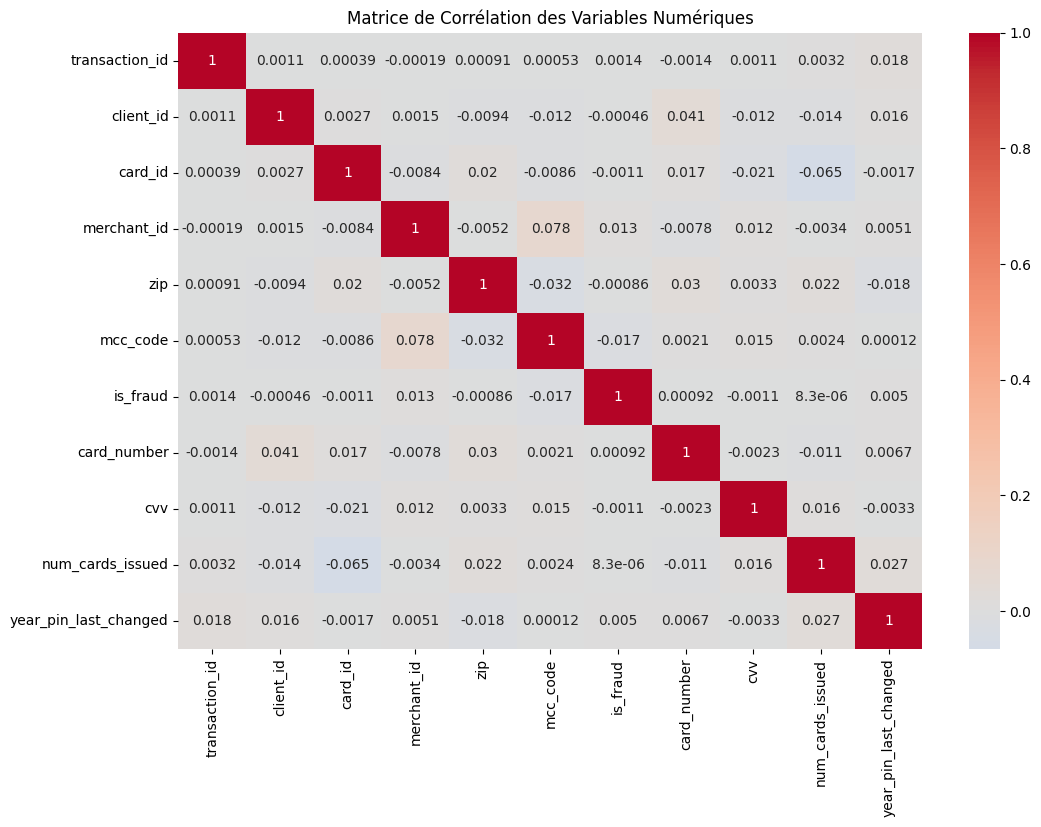

In [10]:
# Rapide diagnostic
if df_merged.empty:
    print('DataFrame principal vide — chargez les fichiers pour exécuter cette cellule')
else:
    #Analyse des valeurs manquantes
    missing_data = df_merged.isnull().sum()
    missing_percent = (missing_data / len(df_merged)) * 100

    print("\n🔍 VALEURS MANQUANTES:")
    missing_info = pd.DataFrame({
        'Valeurs_manquantes': missing_data,
        'Pourcentage': missing_percent
    }).sort_values('Pourcentage', ascending=False)

    display(missing_info.head(20))

    # Doublons sur transaction_id
    if 'transaction_id' in df_merged.columns:
        print('Doublons transaction_id:', df_merged['transaction_id'].duplicated().sum())

    # Variance numérique (exclure colonnes non numériques)
    numeric = df_merged.select_dtypes(include=[np.number])
    if not numeric.empty:
        var = numeric.var().sort_values()
        display(var.head(10))

    # Corrélation matrice (numérique)
    # 5. Heatmap de corrélation (variables numériques)
    numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 8))
        correlation_matrix = df_merged[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Matrice de Corrélation des Variables Numériques')
        plt.show()


In [11]:
def identify_irrelevant_variables(df, missing_threshold=95):
    """Identifie les variables potentiellement peu pertinentes"""

    # Variables avec trop de valeurs manquantes
    high_missing = missing_info[missing_info['Pourcentage'] > missing_threshold].index.tolist()

    # Variables constantes ou à faible variance
    constant_vars = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].nunique() <= 1:
            constant_vars.append(col)

    # Variables de type ID (potentiellement non informatives)
    id_vars = [col for col in df.columns if 'id' in col.lower() and df[col].nunique() == len(df)]

    # Variables textuelles longues (descriptions trop détaillées)
    text_vars = []
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].str.len().mean() > 100:  # Textes trop longs
            text_vars.append(col)

    irrelevant_vars = list(set(high_missing + constant_vars + id_vars + text_vars))

    print("🚫 VARIABLES POTENTIELLEMENT PEU PERTINENTES:")
    for var in irrelevant_vars:
        print(f"- {var}: {df[var].nunique()} valeurs uniques, {df[var].isnull().sum()} valeurs manquantes")

    return irrelevant_vars

irrelevant_vars = identify_irrelevant_variables(df_merged)


🚫 VARIABLES POTENTIELLEMENT PEU PERTINENTES:
- errors: 20 valeurs uniques, 2514144 valeurs manquantes
- transaction_id: 2554758 valeurs uniques, 0 valeurs manquantes


### 1.3.2 Suppressions et conversions proposées
- Supprimer identifiants non utiles en analyse (ex: transaction_id si non requis)
- Traiter valeurs manquantes: imputation ou marquage selon la variable
- Convertir timestamps en datetime, extraire heure et jour


In [12]:
def clean_data(df, irrelevant_vars):
    """Nettoie et prépare le dataset"""

    df_clean = df.copy()

    # 1. Suppression des variables peu pertinentes
    vars_to_drop = [var for var in irrelevant_vars if var in df_clean.columns]
    df_clean = df_clean.drop(columns=vars_to_drop)
    print(f"✅ Variables supprimées: {vars_to_drop}")

    # 2. Gestion des valeurs manquantes
    # Pour les variables numériques: imputation par la médiane
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0 and df_clean[col].isnull().sum() < len(df_clean) * 0.3:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    # Pour les variables catégorielles: imputation par le mode
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0 and df_clean[col].isnull().sum() < len(df_clean) * 0.3:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

    # 3. Suppression des doublons
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    final_rows = len(df_clean)
    print(f"✅ Doublons supprimés: {initial_rows - final_rows}")

    # 4. Correction des types de données
    # Conversion des dates
    date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_columns:
        try:
            df_clean[col] = pd.to_datetime(df_clean[col])
        except:
            print(f"⚠️ Impossible de convertir {col} en datetime")

    # 5. Nettoyage des montants (suppression des symboles $, etc.)
    amount_cols = [col for col in df_clean.columns if 'amount' in col.lower()]
    for col in amount_cols:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].replace('[\$,]', '', regex=True).astype(float)
    amount_cols = [col for col in df_clean.columns if 'credit_limit' in col.lower()]
    for col in amount_cols:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].replace('[\$,]', '', regex=True).astype(float)

    print(f"✅ Dataset nettoyé: {df_clean.shape}")
    return df_clean

df_clean_data = clean_data(df_merged, irrelevant_vars)


✅ Variables supprimées: ['errors', 'transaction_id']
✅ Doublons supprimés: 4
✅ Dataset nettoyé: (2554754, 23)


## 1.4 création de variables dérivées

In [13]:
# Exemple d'opérations de nettoyage et de création de variables dérivées
# Nettoyage du montant et conversion en float
import re
df_clean=df_clean_data.copy()
df_clean['mcc_category'] = (
    df_clean['mcc_description']
    .astype(str)                     # au cas où certaines valeurs ne sont pas str
    .str.split(',| -| and ')         # couper sur virgules, tirets ou "and"
    .str[0]                          # prendre le premier morceau
    .str.strip()                     # enlever espaces
)

def clean_mcc(x: str) -> str:
    if pd.isna(x):
        return "mcc_unknown"
    # mettre en minuscule
    x = str(x).lower()
    # enlever les caractères spéciaux sauf lettres/chiffres/espace
    x = re.sub(r'[^a-z0-9\s]', '', x)
    # remplacer espaces multiples par un seul underscore
    x = re.sub(r'\s+', '_', x.strip())
    return f"mcc_{x}"

# 1. Variables temporelles
date_cols = [col for col in df_clean.columns if 'date' in col.lower() or 'timestamp' in col.lower()]
if date_cols:
    main_date_col = date_cols[0]  # Prendre la première colonne de date disponible
    df_clean['transaction_hour'] = pd.to_datetime(df_clean[main_date_col]).dt.hour
    df_clean['transaction_day'] = pd.to_datetime(df_clean[main_date_col]).dt.day_name()
    df_clean['transaction_month'] = pd.to_datetime(df_clean[main_date_col]).dt.month
    df_clean['is_weekend'] = pd.to_datetime(df_clean[main_date_col]).dt.dayofweek >= 5
    
    # Période de la journée
    def get_time_period(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    
    df_clean['time_period'] = df_clean['transaction_hour'].apply(get_time_period)


df_clean['amount'] = df_clean['amount'].replace(r'[\$,]', '', regex=True).astype(float)

# Quartiles pour catégoriser les montants
q1 = df_clean['amount'].quantile(0.25)
q2 = df_clean['amount'].quantile(0.50)
q3 = df_clean['amount'].quantile(0.75)

def categorize_amount_quartile(x):
    if x <= q1:
        return 'amount_low'
    elif x <= q2:
        return 'amount_medium'
    elif x <= q3:
        return 'amount_high'
    else:
        return 'amount_very_high'

df_clean['amount_item'] = df_clean['amount'].apply(categorize_amount_quartile)

# Catégorisation du credit_score
df_clean['credit_score_item'] = df_clean['credit_limit'].apply(
    lambda x: 'credit_high' if x >= 700 else ('credit_medium' if x >= 500 else 'credit_low')
)

# Transformation type de carte
df_clean['card_type_item'] = df_clean['card_type'].apply(lambda x: f"card_{str(x).lower()}")

# État du commerçant
if 'merchant_state' in df_clean.columns:
    df_clean['merchant_state_item'] = 'state_' + df_clean['merchant_state'].astype(str).str.lower()
# Transformation MCC description
df_clean['mcc_item'] = df_clean['mcc_category'].apply(clean_mcc)


### 1.5 Visualisations exploratoires

Top 10 marchands (par nombre de transactions et par revenu) et périodes de pointe.

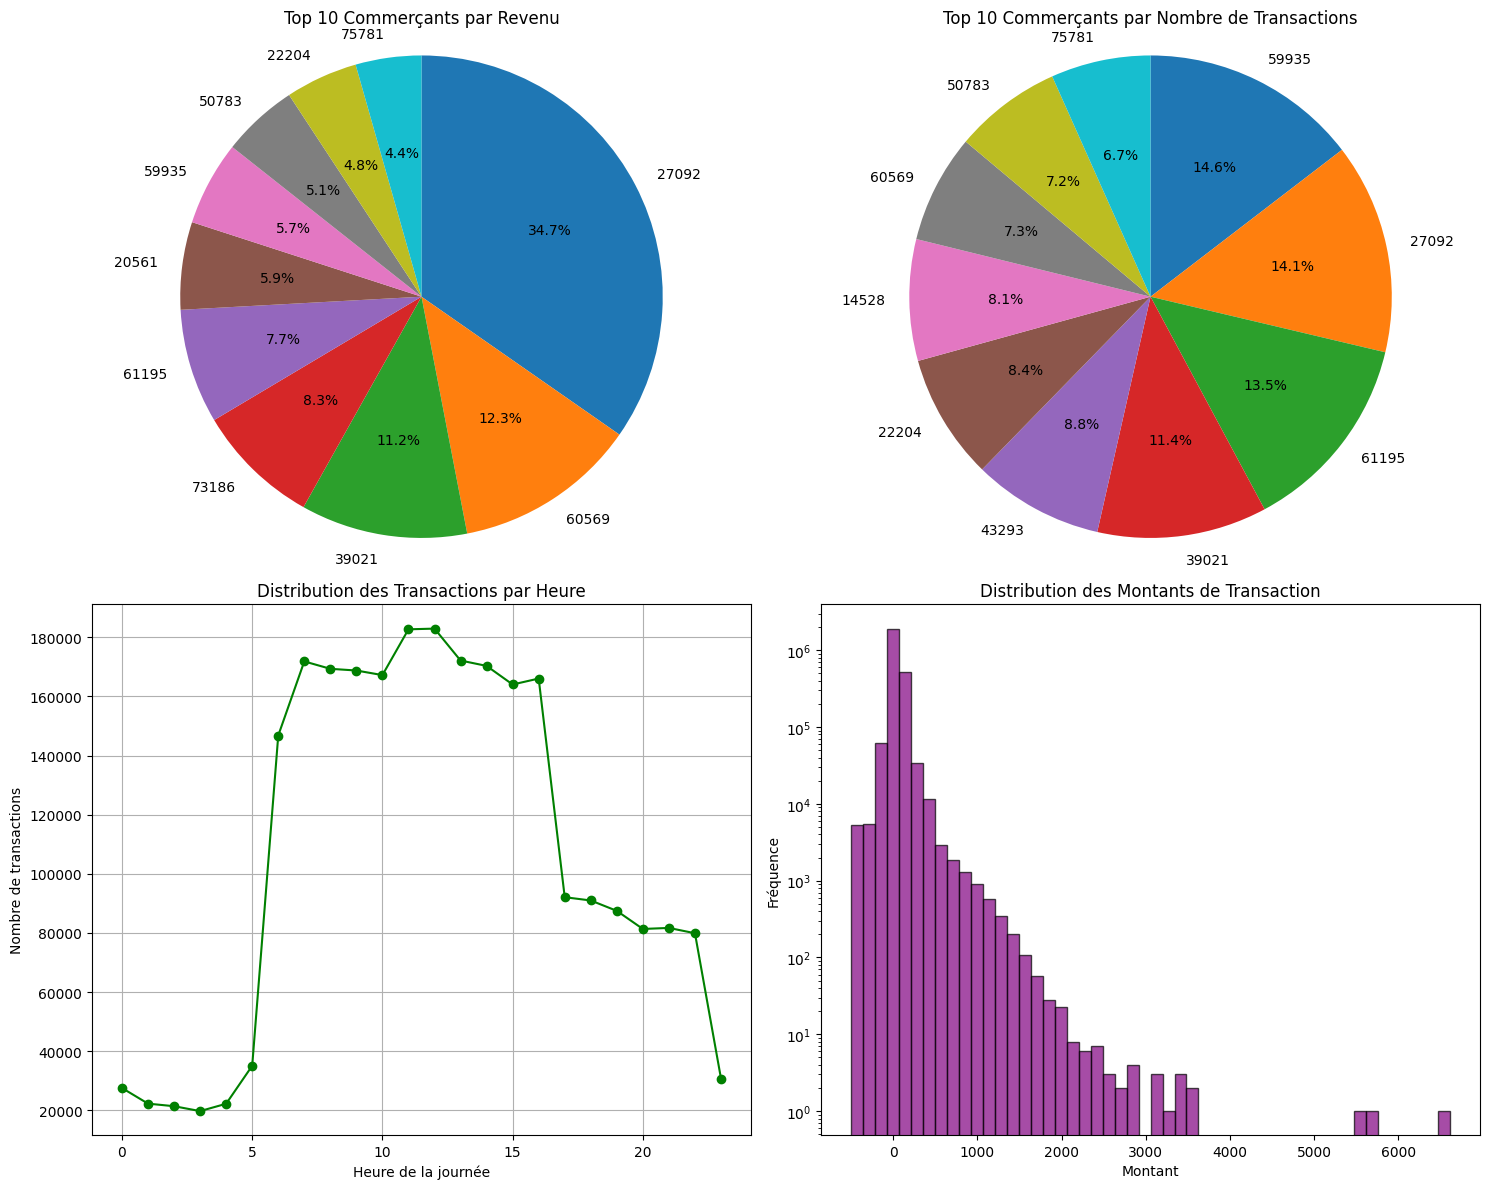

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def create_exploratory_visualizations(df):
    """Crée des visualisations exploratoires : barres + lignes + histogrammes"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    if 'merchant_id' in df.columns and 'amount' in df.columns:
    # Vérifier / convertir la colonne 'amount' en float si nécessaire
        if df['amount'].dtype == object:
            df['amount'] = (
                df['amount'].astype(str)
                .str.replace('$', '', regex=False)
                .str.replace(',', '', regex=False)
                .astype(float)
            )

        # Top 10 commerçants par revenu
        top_merchants_revenue = df.groupby('merchant_id')['amount'].sum().nlargest(10)

        axes[0, 0].pie(
            top_merchants_revenue,
            labels=top_merchants_revenue.index,
            autopct='%1.1f%%',
            startangle=90,
            counterclock=False
        )
        axes[0, 0].set_title('Top 10 Commerçants par Revenu')
        axes[0, 0].axis('equal')  # pour un cercle parfait
    if 'merchant_id' in df.columns:
        top_merchants_count = df['merchant_id'].value_counts().head(10)
        axes[0, 1].pie(
            top_merchants_count,
            labels=top_merchants_count.index,
            autopct='%1.1f%%',
            startangle=90,
            counterclock=False
        )
        axes[0, 1].set_title('Top 10 Commerçants par Nombre de Transactions')
        axes[0, 1].axis('equal')  # rend le camembert circulaire

    # 3. Distribution temporelle des transactions (line chart)
    df['hour'] = pd.to_datetime(df['date']).dt.hour
    if 'hour' in df.columns:
        hourly_transactions = df['hour'].value_counts().sort_index()
        axes[1, 0].plot(hourly_transactions.index, hourly_transactions.values, marker='o', color='green')
        axes[1, 0].set_xlabel('Heure de la journée')
        axes[1, 0].set_ylabel('Nombre de transactions')
        axes[1, 0].set_title('Distribution des Transactions par Heure')
        axes[1, 0].grid(True)

    # 4. Distribution des montants (histogramme log)
    if 'amount' in df.columns:
        axes[1, 1].hist(df['amount'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
        axes[1, 1].set_xlabel('Montant')
        axes[1, 1].set_ylabel('Fréquence')
        axes[1, 1].set_title('Distribution des Montants de Transaction')
        axes[1, 1].set_yscale('log')

    plt.tight_layout()
    plt.show()



# Exécution
create_exploratory_visualizations(df_clean)


 ## 2 Analyse d’association 

## 2.1 Préparation pour l'analyse d'association

### 2.1.1  Transformation en transactions


In [18]:
# Colonnes à transformer en format transactionnel long
cols_to_unstack = ['mcc_item', 'card_type_item','amount_item', 'merchant_state_item','credit_score_item','time_period']

# Base avec identifiants
df_base = df_clean[['client_id', 'card_id']].copy()
df_base.rename(columns={'client_id_x': 'client_id'}, inplace=True)

# Transformation en format long (transaction → item)
df_long = pd.melt(
    pd.concat([df_base, df_clean[cols_to_unstack]], axis=1),
    id_vars=['client_id', 'card_id'],
    value_vars=cols_to_unstack,
    value_name='itemname'
)[['client_id', 'card_id', 'itemname']]

print(df_long.head(10))

# À partir de df_long : (client_id, card_id, itemname)
transactions = df_long.groupby(['card_id','client_id' ])['itemname'].apply(list)
transactions



   client_id  card_id                 itemname
0        316     5857          mcc_drug_stores
1       1954     4879            mcc_utilities
2       1684     2723                mcc_tolls
3        335      353  mcc_recreational_sports
4       1919     1215        mcc_eating_places
5        430     4351       mcc_money_transfer
6        641     5151     mcc_service_stations
7        900     1238        mcc_eating_places
8        361     4703       mcc_grocery_stores
9       1058     4502        mcc_digital_goods


card_id  client_id
0        1362         [mcc_miscellaneous_home_furnishing_stores, mcc...
1        550          [mcc_motion_picture_theaters, mcc_department_s...
2        556          [mcc_miscellaneous_food_stores, mcc_miscellane...
3        1937         [mcc_taxicabs, mcc_service_stations, mcc_taxic...
4        1981         [mcc_miscellaneous_food_stores, mcc_miscellane...
                                            ...                        
6133     425          [mcc_eating_places, mcc_miscellaneous_food_sto...
6134     1492         [mcc_miscellaneous_food_stores, mcc_eating_pla...
6137     1256         [mcc_tolls, mcc_package_stores, mcc_tolls, mcc...
6138     1115         [mcc_miscellaneous_food_stores, mcc_hardware_s...
6144     737          [mcc_airlines, card_credit, amount_very_high, ...
Name: itemname, Length: 3541, dtype: object

### 2.1.2 encodage pour appliquer algo d'analyse d'association

In [82]:
 
# . Transformation en matrice binaire
# ===============================
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

df_binary = pd.DataFrame(te_array, columns=te.columns_)
df_binary


,Afternoon,Evening,Morning,Night,amount_high,amount_low,amount_medium,amount_very_high,card_credit,card_debit,...,state_ut,state_va,state_vatican city,state_venezuela,state_vietnam,state_vt,state_wa,state_wi,state_wv,state_wy
0,True,True,True,True,True,True,True,True,True,False,...,False,True,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,True,False,False,False
2,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,True,True,True,True,True,True,True,True,False,True,...,False,True,False,False,False,False,True,False,False,False
3537,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,True,False,False,False
3538,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3539,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,True,False,False,False


### 2.1.3 Réduction du nombre de colonnes dans une matrice binaire pour eviter saturation de memoire

In [ ]:

def reduce_items(df_binary, min_support=0.01, top_k=50, max_freq=0.95):
    """
    Réduction du nombre de colonnes dans une matrice binaire (transactions x items).
    
    Paramètres
    ----------
    df_binary : pd.DataFrame
        Matrice binaire (transactions x items).
    min_support : float
        Seuil minimal (en proportion des transactions) pour garder un item.
    top_k : int
        Nombre maximum d'items les plus fréquents à conserver (None = tous).
    max_freq : float
        Seuil maximal de fréquence pour éliminer les colonnes trop fréquentes (ex: >95%).

    Retoura
    ------
    df_reduced : pd.DataFrame
        Matrice binaire réduite.
    """
    n_transactions = len(df_binary)
    min_occurrence = int(min_support * n_transactions)

    # 1. Garder seulement les colonnes assez fréquentes
    df_reduced = df_binary.loc[:, df_binary.sum() >= min_occurrence]

    # 2. Supprimer les colonnes trop fréquentes
    df_reduced = df_reduced.loc[:, (df_reduced.mean() <= max_freq)]

    # 3. Garder seulement les top_k items les plus fréquents
    if top_k is not None and df_reduced.shape[1] > top_k:
        top_items = df_reduced.sum().sort_values(ascending=False).head(top_k).index
        df_reduced = df_reduced[top_items]

    print(f"Avant: {df_binary.shape}, Après réduction: {df_reduced.shape}")
    return df_reduced
df_binary=reduce_items(df_binary, min_support=0.01, top_k=10, max_freq=0.95)

Avant: (3541, 10), Après réduction: (3541, 10)


In [96]:
df_binary

,mcc_eating_places,mcc_utilities,mcc_lumber,mcc_fast_food_restaurants,mcc_telecommunication_services,credit_high,mcc_money_transfer,mcc_beauty,mcc_book_stores,mcc_motion_picture_theaters
0,True,True,True,True,True,True,True,True,False,True
1,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True
4,False,True,True,False,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
3536,True,True,True,True,True,True,True,True,True,True
3537,True,True,True,True,True,True,True,True,True,True
3538,True,True,True,True,True,True,True,True,False,True
3539,True,True,True,False,True,True,True,True,True,False


### 2.2 Appliquer FP-Growth

In [84]:
# 1. FP-Growth (rapide)
# ===============================
frequent_itemsets = fpgrowth(df_binary, min_support=0.5, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
rules.sort_values(["support", "confidence","lift"],axis = 0, 
                                                  ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
12,(mcc_fast_food_restaurants),(mcc_eating_places),0.925445,0.942107,0.919232,0.993287,1.054325,1.0,0.047364,8.623463,0.691108,0.969327,0.884037,0.984503
13,(mcc_eating_places),(mcc_fast_food_restaurants),0.942107,0.925445,0.919232,0.975719,1.054325,1.0,0.047364,3.070570,0.890012,0.969327,0.674328,0.984503
0,(mcc_utilities),(mcc_eating_places),0.929398,0.942107,0.879130,0.945913,1.004040,1.0,0.003538,1.070375,0.056996,0.885885,0.065748,0.939533
1,(mcc_eating_places),(mcc_utilities),0.942107,0.929398,0.879130,0.933153,1.004040,1.0,0.003538,1.056173,0.069507,0.885885,0.053186,0.939533
3,(mcc_lumber),(mcc_eating_places),0.926010,0.942107,0.873764,0.943580,1.001564,1.0,0.001365,1.026119,0.021107,0.878728,0.025454,0.935519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27113,"(mcc_fast_food_restaurants, mcc_eating_places)","(mcc_motion_picture_theaters, mcc_lumber, mcc_...",0.919232,0.528099,0.500424,0.544393,1.030854,1.0,0.014978,1.035763,0.370570,0.528482,0.034528,0.745993
27149,(mcc_fast_food_restaurants),"(mcc_eating_places, mcc_lumber, mcc_motion_pic...",0.925445,0.510308,0.500424,0.540738,1.059632,1.0,0.028162,1.066260,0.754825,0.535024,0.062142,0.760685
27151,(mcc_lumber),"(mcc_fast_food_restaurants, mcc_eating_places,...",0.926010,0.522734,0.500424,0.540409,1.033813,1.0,0.016367,1.038458,0.442039,0.527695,0.037034,0.748865
27153,(mcc_utilities),"(mcc_fast_food_restaurants, mcc_eating_places,...",0.929398,0.522169,0.500424,0.538438,1.031157,1.0,0.015121,1.035248,0.427975,0.526128,0.034048,0.748397


### 2.3 Visualisation des règles

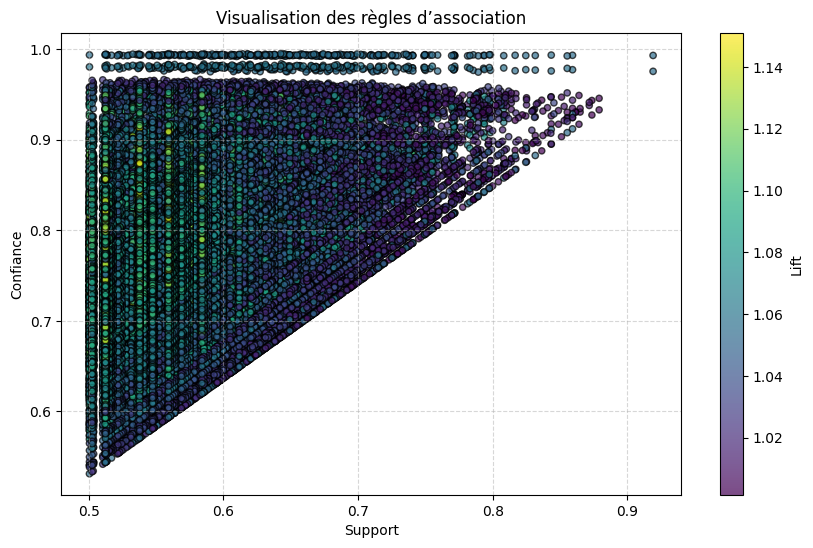

In [85]:
def plot_rules(rules):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        rules['support'],
        rules['confidence'],
        s=rules['lift']*20,
        c=rules['lift'],
        cmap='viridis',
        alpha=0.7,
        edgecolors='k'
    )
    plt.colorbar(scatter, label='Lift')
    plt.title('Visualisation des règles d’association')
    plt.xlabel('Support')
    plt.ylabel('Confiance')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
plot_rules(rules)

### 2.4 Analyse des patterns comportementaux


In [86]:
def analyze_behavioral_patterns(rules, df):
    """Analyse les patterns comportementaux spécifiques"""
    
    print("🔍 ANALYSE DES PATTERNS COMPORTEMENTAUX")
    
    # Convertir en string si nécessaire
    rules['antecedents'] = rules['antecedents'].astype(str)
    rules['consequents'] = rules['consequents'].astype(str)
    
    # 1. Associations avec les codes MCC
    mcc_rules = rules[rules['antecedents'].str.contains('mcc_') | 
                     rules['consequents'].str.contains('mcc_')]
    
    if not mcc_rules.empty:
        print("\n📊 RÈGLES AVEC CODES MCC:")
        for _, rule in mcc_rules.head(5).iterrows():
            print(f"- {rule['antecedents']} → {rule['consequents']}")
            print(f"  Support: {rule['support']:.3f}, Confiance: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
    
    # 2. Associations avec les types de cartes
    card_rules = rules[rules['antecedents'].str.contains('card_type_') | 
                      rules['consequents'].str.contains('card_type_')]
    
    if not card_rules.empty:
        print("\n💳 RÈGLES AVEC TYPES DE CARTES:")
        for _, rule in card_rules.head(5).iterrows():
            print(f"- {rule['antecedents']} → {rule['consequents']}")
    
    # 3. Associations avec les montants élevés
    high_amount_rules = rules[rules['antecedents'].str.contains('amount_high|amount_very_high') | 
                             rules['consequents'].str.contains('amount_high|amount_very_high')]
    
    if not high_amount_rules.empty:
        print("\n💰 RÈGLES AVEC MONTANTS ÉLEVÉS:")
        for _, rule in high_amount_rules.head(5).iterrows():
            print(f"- {rule['antecedents']} → {rule['consequents']}")
    
    # 4. Associations avec la fraude (si disponible)
    if 'is_fraud' in df.columns:
        fraud_rules = rules[rules['consequents'].str.contains('is_fraud')]
        if not fraud_rules.empty:
            print("\n🚨 RÈGLES ASSOCIÉES À LA FRAUDE:")
            for _, rule in fraud_rules.head(5).iterrows():
                print(f"- {rule['antecedents']} → {rule['consequents']}")

# Appel
analyze_behavioral_patterns(rules, df_clean)


🔍 ANALYSE DES PATTERNS COMPORTEMENTAUX

📊 RÈGLES AVEC CODES MCC:
- frozenset({'mcc_utilities'}) → frozenset({'mcc_eating_places'})
  Support: 0.879, Confiance: 0.946, Lift: 1.004
- frozenset({'mcc_eating_places'}) → frozenset({'mcc_utilities'})
  Support: 0.879, Confiance: 0.933, Lift: 1.004
- frozenset({'mcc_eating_places'}) → frozenset({'mcc_lumber'})
  Support: 0.874, Confiance: 0.927, Lift: 1.002
- frozenset({'mcc_lumber'}) → frozenset({'mcc_eating_places'})
  Support: 0.874, Confiance: 0.944, Lift: 1.002
- frozenset({'mcc_utilities'}) → frozenset({'mcc_lumber'})
  Support: 0.872, Confiance: 0.938, Lift: 1.013


## 3. Analyse de séquences (simplifiée)

### 3.1 Construction des séquences de transactions par client 

In [9]:
def build_transaction_sequences(df, client_id_col='client_id', date_col='date'):
    """
    Construit des séquences ordonnées de transactions par client
    """
    # Vérification colonne date
    if date_col not in df.columns:
        raise ValueError(f"Colonne {date_col} manquante dans le DataFrame")
    
    # Conversion en datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Trier par client et date
    df_sorted = df.sort_values([client_id_col, date_col])
    
    # Construire séquences basées sur MCC code
    sequences = df_sorted.groupby(client_id_col)['mcc_code'].apply(list).tolist()
    
    print(f"✅ {len(sequences)} séquences construites")
    return sequences, df_sorted



In [10]:
sequences, df_sorted = build_transaction_sequences(df_clean)

✅ 1209 séquences construites


### 3.2 Extraction de motifs fréquents avec PrefixSpan (Q2 & Q3)

In [11]:
def extract_frequent_patterns(sequences, top_k=10, min_len=2):
    """
    Extrait les k motifs les plus fréquents avec PrefixSpan
    """
    ps = PrefixSpan(sequences)
    patterns = ps.topk(top_k)  # retourne (support, motif)
    
    # Filtrer par longueur minimale
    patterns = [(sup, seq) for sup, seq in patterns if len(seq) >= min_len]
    
    print(f"\n📊 Top-{top_k} motifs fréquents (longueur >= {min_len}):")
    for sup, seq in patterns:
        print(f"Support={sup}, Motif={seq}")
    
    return patterns

patterns = extract_frequent_patterns(sequences, top_k=5, min_len=2)


📊 Top-5 motifs fréquents (longueur >= 2):
Support=1209, Motif=[5541, 5541]
Support=1209, Motif=[5541, 5541, 5541]
Support=1209, Motif=[5541, 5541, 5541, 5912]
Support=1209, Motif=[5541, 5541, 5541, 5912, 5300]


### 3.3 Identifier les motifs précédant une fraude (Q4)

In [12]:
def analyze_fraud_sequences(df, client_id_col='client_id', target_col='is_fraud'):
    """
    Analyse les séquences qui mènent à une transaction frauduleuse
    """
    fraud_sequences = df[df[target_col] == 1].groupby(client_id_col)['mcc_code'].apply(list).tolist()
    
    print("\n⚠️ Séquences menant à fraude :")
    for seq in fraud_sequences:
        print(seq)
    
    # Extraire sous-séquences avant la fraude
    precursors = [seq[:-1] for seq in fraud_sequences if len(seq) > 1]
    print("\n🔍 Motifs précédant la fraude :")
    for seq in precursors:
        print(seq)
    
    return fraud_sequences, precursors

fraud_sequences, precursors = analyze_fraud_sequences(df_sorted)


⚠️ Séquences menant à fraude :
[3684, 7230, 5094, 5932, 4121, 5211, 5310, 3684, 3684, 5921]
[5912, 5947, 5411]
[5311, 5932, 5310]
[4214, 5411, 5912, 5712, 5411, 5499, 5311]
[5932, 5912, 5094, 3722, 3722]
[5310, 5541, 5310, 5310, 5310, 5411, 5311, 5411, 5712]
[5094, 5311, 5211, 3684, 3684, 5311, 4112, 4131, 5812]
[5310, 5712, 5310, 5411, 5310, 5311, 5661, 5541, 5651, 5310, 5311, 5311]
[5311, 3722, 5094, 5310, 3389, 5912, 5311, 5651, 5541, 5541, 5812, 5912, 5094]
[5311, 5310, 5932, 3504, 5311, 5651, 5094, 5311, 5541, 5411]
[5411, 5541, 4214]
[5411, 3389, 3389, 5912]
[4121, 5912, 5311, 5310, 5541, 5311, 5912, 5411]
[5311, 5411, 5411, 3389, 3389, 5311, 5311]
[5311, 5932, 5311, 5712, 5211, 3005, 5311, 5812, 5311]
[3722, 5311, 3722, 3504, 7011, 5932]
[5310, 5311, 3722, 3722, 3722, 5921, 5411, 5499, 4214, 3006]
[5045, 5411, 5310, 5311, 5812, 3009, 5712, 5311, 5311, 5813, 5912]
[5541, 7011, 5912, 5411]
[4121, 5921, 5310, 5310, 5311, 5311, 3144]
[5311, 5311, 5411, 4214, 5411, 5311, 5651, 5541]

### 3.4 Graphe de transitions entre types de transactions (Q6)

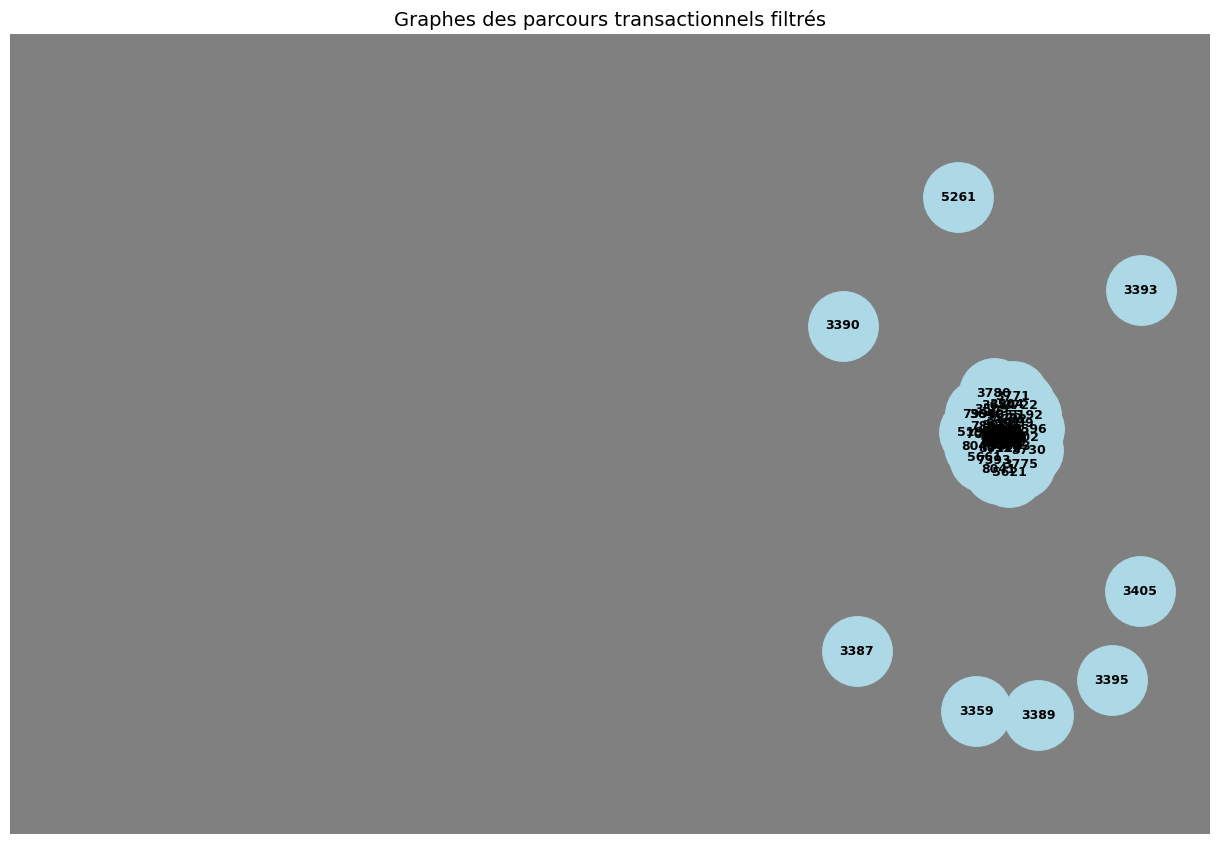

In [14]:
def plot_transition_graph(sequences, min_edge_weight=200):
    """
    Visualise les transitions entre types de transactions via un graphe orienté filtré
    """
    G = nx.DiGraph()
    
    # Construire le graphe avec pondération
    for seq in sequences:
        for i in range(len(seq) - 1):
            src, tgt = seq[i], seq[i + 1]
            if G.has_edge(src, tgt):
                G[src][tgt]['weight'] += 1
            else:
                G.add_edge(src, tgt, weight=1)
    
    # Filtrer les arêtes faibles
    edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= min_edge_weight]
    H = G.edge_subgraph(edges_to_keep).copy()
    
    if len(H.edges) == 0:
        print("⚠️ Aucun motif séquentiel significatif au-dessus du seuil.")
        return

    # Dessiner le graphe
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(H, k=0.7, seed=42)
    nx.draw(H, pos, with_labels=True, node_size=2500,
            node_color="lightblue", font_size=9, font_weight="bold")
    nx.draw_networkx_edges(
        H, pos, arrowstyle="->", arrowsize=15, edge_color="gray",
        width=[d['weight']/50 for (_, _, d) in H.edges(data=True)]  # mise à l’échelle
    )
    plt.title("Graphes des parcours transactionnels filtrés", fontsize=14)
    plt.axis("off")
    plt.show()
plot_transition_graph(sequences)

## 4. Système de recommandation (basé sur règles d'association)

4.1 Exporter un script `recommender.py` réutilisable.

In [34]:
# Création du fichier recommender.py depuis le Notebook
reco_script = r"""# recommender.py
import json
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from prefixspan import PrefixSpan

# =============================
# 1. RÈGLES D’ASSOCIATION
# =============================
def fit_rules(transactions, min_support=0.005, min_lift=1.1, top_k=50, max_freq=0.95):
    


    # 1️⃣ Encoder les transactions en matrice binaire
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_te = pd.DataFrame(te_ary, columns=te.columns_)

    # 2️⃣ Réduction des items rares ou trop fréquents
    n_transactions = len(df_te)
    min_occurrence = int(min_support * n_transactions)

    # Supprimer les items trop rares
    df_reduced = df_te.loc[:, df_te.sum() >= min_occurrence]

    # Supprimer les items trop fréquents
    df_reduced = df_reduced.loc[:, (df_reduced.mean() <= max_freq)]

    # Garder seulement les top_k plus fréquents
    if top_k is not None and df_reduced.shape[1] > top_k:
        top_items = df_reduced.sum().sort_values(ascending=False).head(top_k).index
        df_reduced = df_reduced[top_items]

    # 3️⃣ Extraction des itemsets fréquents et génération des règles
    frequent_itemsets = apriori(df_reduced, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric='lift', min_threshold=min_lift)

    return rules


# =============================
# 2. MOTIFS SÉQUENTIELS
# =============================
def fit_sequences(sequences, min_support=0.01, top_k=50):
    ps = PrefixSpan(sequences)
    patterns = ps.topk(top_k)
    return [(sup, seq) for sup, seq in patterns if len(seq) >= 2]

def recommend_next_from_sequence(history_sequence, patterns, top_n=3):
    history_tuple = tuple(history_sequence)
    candidates = {}
    for sup, seq in patterns:
        if len(seq) > len(history_tuple) and tuple(seq[:len(history_tuple)]) == history_tuple:
            next_item = seq[len(history_tuple)]
            candidates[next_item] = candidates.get(next_item, 0) + sup
    ranked = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    return ranked[:top_n]
"""
with open('recommender.py', 'w', encoding='utf-8') as f:
    f.write(reco_script)

print("✅ Fichier recommender.py créé avec succès.")


✅ Fichier recommender.py créé avec succès.


### 4.2 importer recommender et utilsier


In [49]:
import importlib
import recommender
importlib.reload(recommender)


<module 'recommender' from 'c:\\Users\\ismai\\recommender.py'>

In [50]:
rules = recommender.fit_rules(transactions, min_support=0.05, min_lift=1.0, top_k=10)
print(rules.head(10))



                        antecedents                       consequents  \
0               (mcc_eating_places)                   (mcc_utilities)   
1                   (mcc_utilities)               (mcc_eating_places)   
2               (mcc_eating_places)                      (mcc_lumber)   
3                      (mcc_lumber)               (mcc_eating_places)   
4               (mcc_eating_places)       (mcc_fast_food_restaurants)   
5       (mcc_fast_food_restaurants)               (mcc_eating_places)   
6               (mcc_eating_places)  (mcc_telecommunication_services)   
7  (mcc_telecommunication_services)               (mcc_eating_places)   
8                     (credit_high)               (mcc_eating_places)   
9               (mcc_eating_places)                     (credit_high)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.942107            0.929398  0.879130    0.933153  1.004040   
1            0.929398            0.942107 

In [52]:
history = ["mcc_eating_places", "credit_high"]
recs = recommender.recommend_from_history(history, rules, top_n=5)
print("Recommandations pour", history, ":", recs)


Recommandations pour ['mcc_eating_places', 'credit_high'] : [('mcc_fast_food_restaurants', 472.23358215957614), ('mcc_utilities', 464.4397519096183), ('mcc_telecommunication_services', 462.87628150964963), ('mcc_lumber', 460.86846471789335), ('mcc_money_transfer', 459.22266326147394)]


## 5. Analyse statistique comparative entre classes (fraude vs légitime)

5.1 Tests univariés et comparaison ACP / t-SNE / UMAP.

### 5.1.1  Encodage des variables catégorielles

In [101]:
def encode_categorical_variables(df):
    """Encode les variables catégorielles selon leur nature"""

    df_encoded = df.copy()
    encoding_report = {}

    # Identifier les variables catégorielles
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        unique_count = df_encoded[col].nunique()

        # One-Hot Encoding si peu de catégories
        if unique_count <= 10:
            dummies = pd.get_dummies(df_encoded[col], prefix=col).astype(int)  # ✅ 0/1 au lieu de True/False
            df_encoded = pd.concat([df_encoded.drop(columns=[col]), dummies], axis=1)
            encoding_report[col] = f'One-Hot Encoding ({unique_count} catégories)'

        # Label Encoding si beaucoup de catégories
        else:
            le = LabelEncoder()
            df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
            df_encoded.drop(columns=[col], inplace=True)
            encoding_report[col] = f'Label Encoding ({unique_count} catégories)'

    # Afficher le rapport
    print("📊 RAPPORT D'ENCODAGE:")
    for col, method in encoding_report.items():
        print(f"- {col}: {method}")

    return df_encoded

df_com=df_clean_data.copy()
df_2d = encode_categorical_variables(df_com)


📊 RAPPORT D'ENCODAGE:
- use_chip: One-Hot Encoding (3 catégories)
- merchant_city: Label Encoding (8805 catégories)
- merchant_state: Label Encoding (137 catégories)
- mcc_description: Label Encoding (108 catégories)
- card_brand: One-Hot Encoding (4 catégories)
- card_type: One-Hot Encoding (3 catégories)
- expires: Label Encoding (85 catégories)
- has_chip: One-Hot Encoding (2 catégories)
- card_on_dark_web: One-Hot Encoding (1 catégories)


Top features pour réduction de dimension (ANOVA):
                        feature  anova_score        p_value
14        merchant_city_encoded  2707.105932   0.000000e+00
2                        amount   731.390383  4.829244e-161
16      mcc_description_encoded   518.150415  1.111820e-114
5                      mcc_code   485.502143  1.404467e-107
11    use_chip_Chip Transaction   411.638038   1.653356e-91
3                   merchant_id   282.147342   2.586684e-63
12  use_chip_Online Transaction   240.787968   2.670556e-54
22              card_type_Debit   145.620666   1.576279e-33
15       merchant_state_encoded   129.205195   6.130909e-30
21             card_type_Credit   123.361906   1.164611e-28
13   use_chip_Swipe Transaction   122.405383   1.885975e-28
9                  credit_limit    56.023747   7.163493e-14
10        year_pin_last_changed    43.339729   4.602773e-11
18          card_brand_Discover    43.153672   5.061922e-11
4                           zip    38.000292   7.0

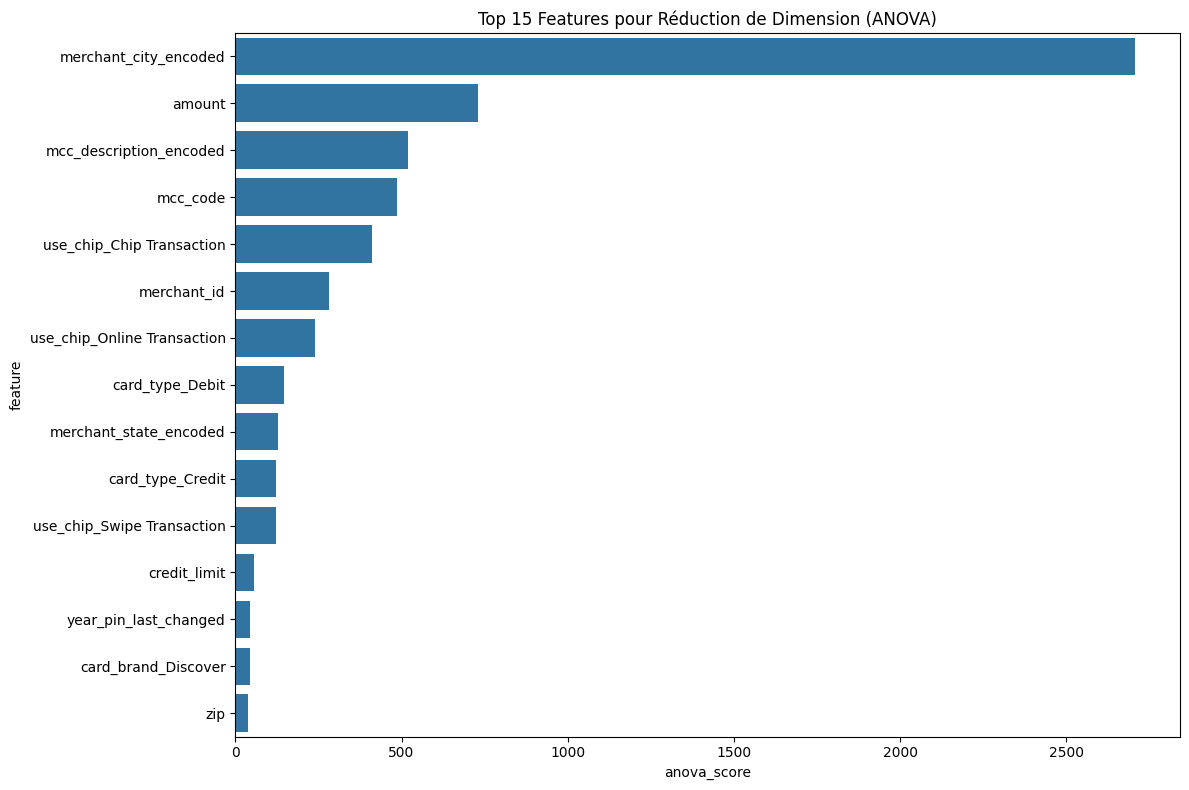

In [105]:
from sklearn.feature_selection import SelectKBest, f_classif

# Préparer les données
df_2d = df_2d.select_dtypes(exclude=['datetime64[ns]', 'datetime64[ns, UTC]'])
df_2d.dropna(inplace=True)
all_features=df_2d.columns
Xc = df_2d.drop(columns='is_fraud')
yc = df_2d['is_fraud']
all_features=Xc.columns
# Sélection ANOVA
selector_anova = SelectKBest(score_func=f_classif, k=15)
X_anova = selector_anova.fit_transform(Xc, yc)

# Obtenir les scores
anova_scores = pd.DataFrame({
    'feature': all_features,
    'anova_score': selector_anova.scores_,
    'p_value': selector_anova.pvalues_
}).sort_values('anova_score', ascending=False)

print("Top features pour réduction de dimension (ANOVA):")
print(anova_scores.head(15))

# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(data=anova_scores.head(15), y='feature', x='anova_score')
plt.title('Top 15 Features pour Réduction de Dimension (ANOVA)')
plt.tight_layout()
plt.show()

In [106]:
final_recommendation = [
    'use_chip_Online Transaction',   # 🥇 Canal le plus risqué
    'use_chip_Swipe Transaction',    # 🥈 Canal traditionnel à risque
    'amount',                        # 🥇 Variable financière clé
    'merchant_state_encoded',        # 🥇 Hotspots géographiques
    'merchant_city_encoded',         # 🥇 Zones spécifiques à risque
    'mcc_description_encoded',       # 🥉 Secteurs vulnérables
    'credit_limit',                  # 🥉 Profil client
    'card_type_Debit (Prepaid)'      # 🥉 Type de carte risqué
]

Shape X, y: (50000, 8) (50000,)
Distribution des classes: is_fraud
0    49913
1       87
Name: count, dtype: int64

=== TESTS UNIVARIÉS ===

amount:
  T-test: p-value = 0.000000 ***
  Mann-Whitney: p-value = 0.000000 ***
  KS-test: p-value = 0.000000 ***
  Moyenne Fraude: 82.55, Légitime: 42.58

credit_limit:
  T-test: p-value = 0.000000 ***
  Mann-Whitney: p-value = 0.000000 ***
  KS-test: p-value = 0.000000 ***
  Moyenne Fraude: 14003.38, Légitime: 15667.78

expires_encoded:
  T-test: p-value = 0.047874 *
  Mann-Whitney: p-value = 0.041263 *
  KS-test: p-value = 0.000503 ***
  Moyenne Fraude: 41.03, Légitime: 41.92


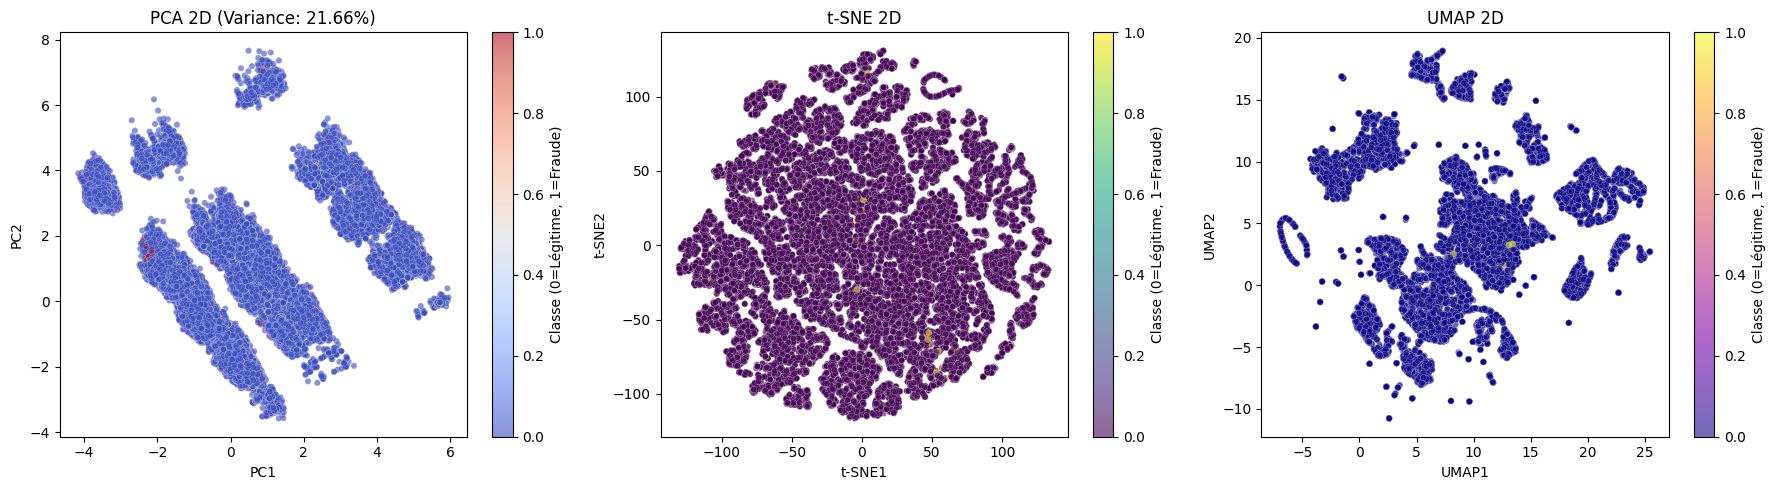

In [107]:

# Vérification et préparation des données
if not df_2d.empty and 'is_fraud' in df_2d.columns:
    # Échantillonnage stratifié
    sample_df, _ = train_test_split(
        df_2d,
        train_size=50000,
        stratify=df_2d['is_fraud'],
        random_state=42
    )
    
    # Préparation des données - CORRECTION: éviter la duplication
    df_sample = sample_df.fillna(0)
    y = df_sample['is_fraud'].astype(int)  # Une seule assignation
    X = df_sample[final_recommendation].select_dtypes(include=[np.number])
    df_sample = sample_df.fillna(0)
    ypca = df_2d['is_fraud'].astype(int)  # Une seule assignation
    Xpca = df_2d.select_dtypes(include=[np.number])
    print('Shape X, y:', X.shape, y.shape)
    print('Distribution des classes:', y.value_counts())
    
    # Tests univariés étendus
    from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp
    
    numerical_features = ['amount', 'credit_limit', 'expires_encoded']
    
    print("\n=== TESTS UNIVARIÉS ===")
    for feature in numerical_features:
        if feature in df_2d.columns:
            fraud_data = df_2d[df_2d['is_fraud'] == 1][feature].dropna()
            legit_data = df_2d[df_2d['is_fraud'] == 0][feature].dropna()
            
            if len(fraud_data) > 1 and len(legit_data) > 1:
                # T-test
                t_stat, t_p = ttest_ind(fraud_data, legit_data, equal_var=False)
                # Mann-Whitney
                mw_stat, mw_p = mannwhitneyu(fraud_data, legit_data)
                # Kolmogorov-Smirnov
                ks_stat, ks_p = ks_2samp(fraud_data, legit_data)
                
                print(f"\n{feature}:")
                print(f"  T-test: p-value = {t_p:.6f} {'***' if t_p < 0.001 else '**' if t_p < 0.01 else '*' if t_p < 0.05 else ''}")
                print(f"  Mann-Whitney: p-value = {mw_p:.6f} {'***' if mw_p < 0.001 else '**' if mw_p < 0.01 else '*' if mw_p < 0.05 else ''}")
                print(f"  KS-test: p-value = {ks_p:.6f} {'***' if ks_p < 0.001 else '**' if ks_p < 0.01 else '*' if ks_p < 0.05 else ''}")
                print(f"  Moyenne Fraude: {fraud_data.mean():.2f}, Légitime: {legit_data.mean():.2f}")

    # Standardisation
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    Xpc = scaler.fit_transform(Xpca)
    # Visualisation 2D
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
   # PCA 2D
    pca_2d = PCA(n_components=2, random_state=42)
    X_pca_2d = pca_2d.fit_transform(Xpc)  # Correction: Xs au lieu de Xpc
    scatter0 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=ypca, alpha=0.6, cmap='coolwarm', 
                            s=20, edgecolors='white', linewidth=0.2)
    axes[0].set_title(f'PCA 2D (Variance: {pca_2d.explained_variance_ratio_.sum():.2%})')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    cbar0 = plt.colorbar(scatter0, ax=axes[0])
    cbar0.set_label('Classe (0=Légitime, 1=Fraude)')

    # t-SNE 2D
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne_2d = tsne_2d.fit_transform(Xs)
    scatter1 = axes[1].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y, alpha=0.6, cmap='viridis',
                            s=20, edgecolors='white', linewidth=0.2)
    axes[1].set_title('t-SNE 2D')
    axes[1].set_xlabel('t-SNE1')
    axes[1].set_ylabel('t-SNE2')
    cbar1 = plt.colorbar(scatter1, ax=axes[1])
    cbar1.set_label('Classe (0=Légitime, 1=Fraude)')

    # UMAP 2D
    umap_2d = umap.UMAP(random_state=42)
    X_umap_2d = umap_2d.fit_transform(Xs)
    scatter2 = axes[2].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y, alpha=0.6, cmap='plasma',
                            s=20, edgecolors='white', linewidth=0.2)
    axes[2].set_title('UMAP 2D')
    axes[2].set_xlabel('UMAP1')
    axes[2].set_ylabel('UMAP2')
    cbar2 = plt.colorbar(scatter2, ax=axes[2])
    cbar2.set_label('Classe (0=Légitime, 1=Fraude)')

    plt.tight_layout()
    plt.show()

else:
    print('Dataframe vide ou colonne is_fraud inexistante')

In [ ]:
def plot_3d(data, labels, title, method="PCA"):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_labels = sorted(set(labels))
    palette = sns.color_palette("husl", len(unique_labels))
    
    # Noms des classes
    class_names = {0: "Légitime", 1: "Fraude"}
    
    for i, label in enumerate(unique_labels):
        indices = labels == label
        
        # CORRECTION: Utiliser l'ordre correct des dimensions
        ax.scatter(
            data[indices, 0],  # Dimension 1 pour X
            data[indices, 1],  # Dimension 2 pour Y
            data[indices, 2],  # Dimension 3 pour Z
            label=class_names.get(label, f'Classe {label}'),
            s=30 if label == 1 else 10,  # Points plus gros pour la fraude
            alpha=0.9 if label == 1 else 0.3,  # Plus opaque pour la fraude
            color=palette[i],
            edgecolors='white',
            linewidth=0.1,
            depthshade=True
        )
    
    ax.set_title(f'{title}\n({method} 3D)', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{method} 1')
    ax.set_ylabel(f'{method} 2') 
    ax.set_zlabel(f'{method} 3')
    
    # Améliorer la légende
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
    
    # Angle de vue pour mieux voir la séparation
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    # Informations supplémentaires
    print(f"Dimensions de l'espace 3D: {data.shape}")
    print(f"Répartition des classes: {dict(zip(*np.unique(labels, return_counts=True)))}")


=== RÉDUCTIONS DE DIMENSION 3D ===
Variance expliquée PCA 3D: [9.29944889e-01 6.99724682e-02 4.14319955e-05]
Variance totale: 100.00%
Calcul t-SNE 3D en cours...
Calcul UMAP 3D en cours...


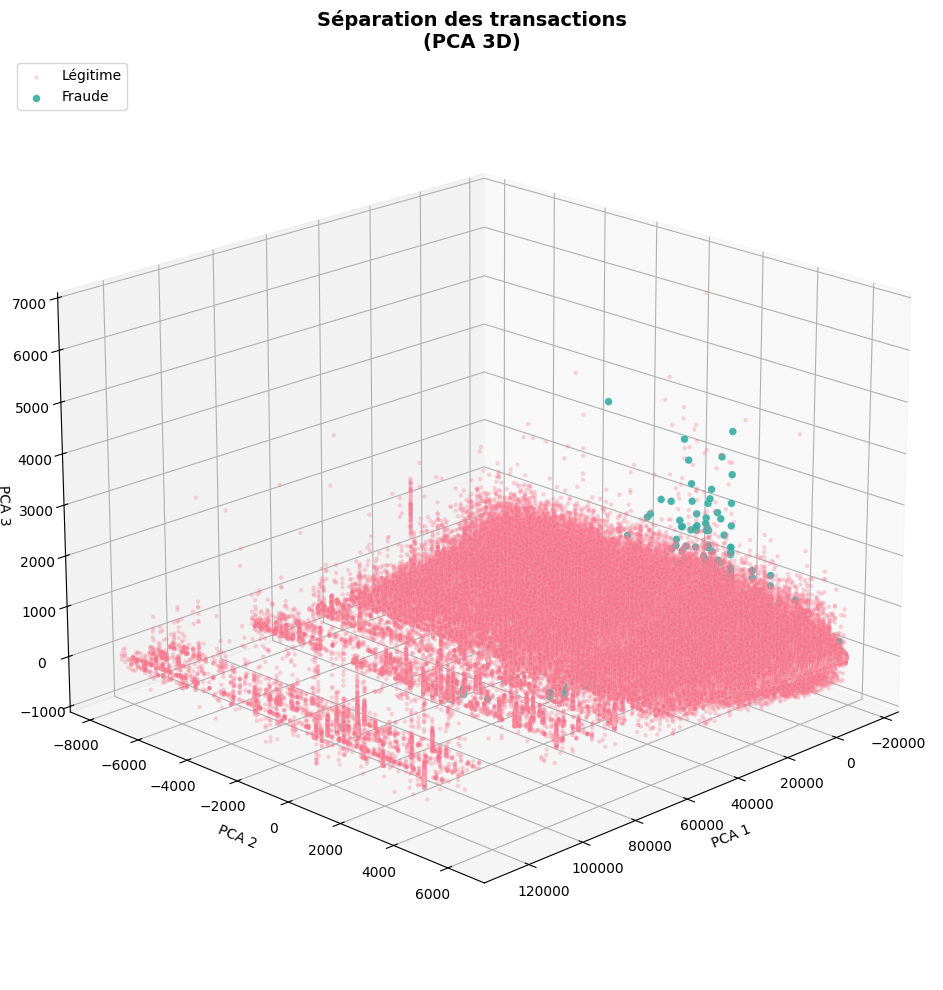

Dimensions de l'espace 3D: (8914917, 3)
Répartition des classes: {0: 8901585, 1: 13332}


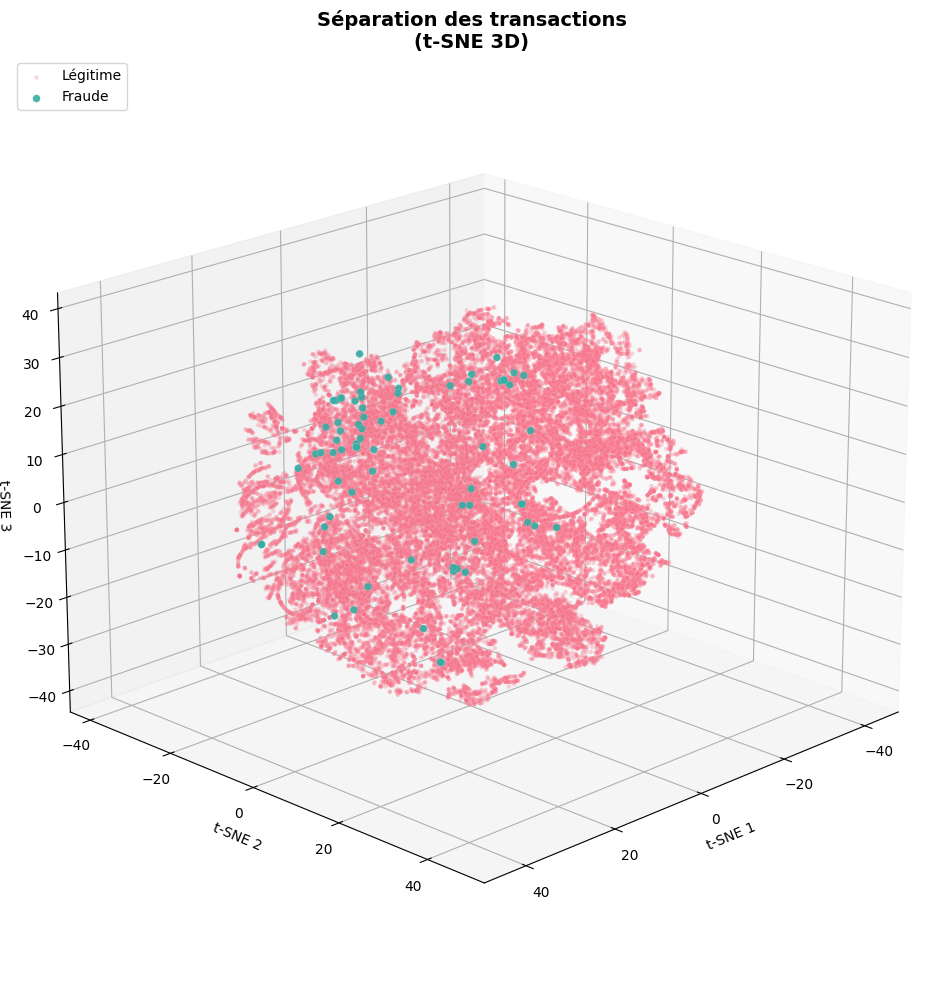

Dimensions de l'espace 3D: (50000, 3)
Répartition des classes: {0: 49925, 1: 75}


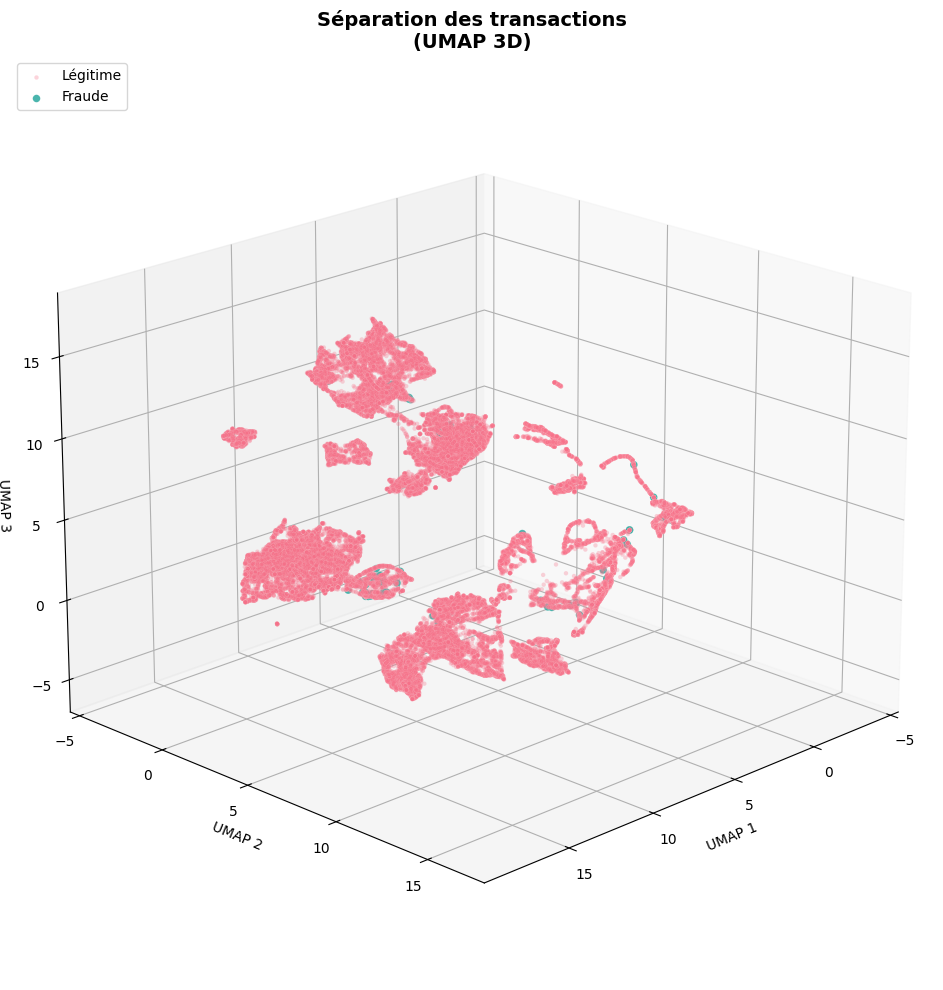

Dimensions de l'espace 3D: (50000, 3)
Répartition des classes: {0: 49925, 1: 75}


In [ ]:
# Réductions de dimension 3D
print("\n=== RÉDUCTIONS DE DIMENSION 3D ===")

# PCA 3D
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(Xpca)
print(f"Variance expliquée PCA 3D: {pca_3d.explained_variance_ratio_}")
print(f"Variance totale: {sum(pca_3d.explained_variance_ratio_):.2%}")

# t-SNE 3D (peut être long)
print("Calcul t-SNE 3D en cours...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(Xs)

# UMAP 3D
print("Calcul UMAP 3D en cours...")
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(Xs)

# Visualisations 3D
plot_3d(X_pca_3d, ypca, "Séparation des transactions", "PCA")
plot_3d(X_tsne_3d, y, "Séparation des transactions", "t-SNE")
plot_3d(X_umap_3d, y, "Séparation des transactions", "UMAP")

## 10. Analyse multivariée et conclusion

Exemple d'application d'une méthode multivariée (LDA) et synthèse des résultats.


=== ANALYSE DISCRIMINANTE LINÉAIRE ===


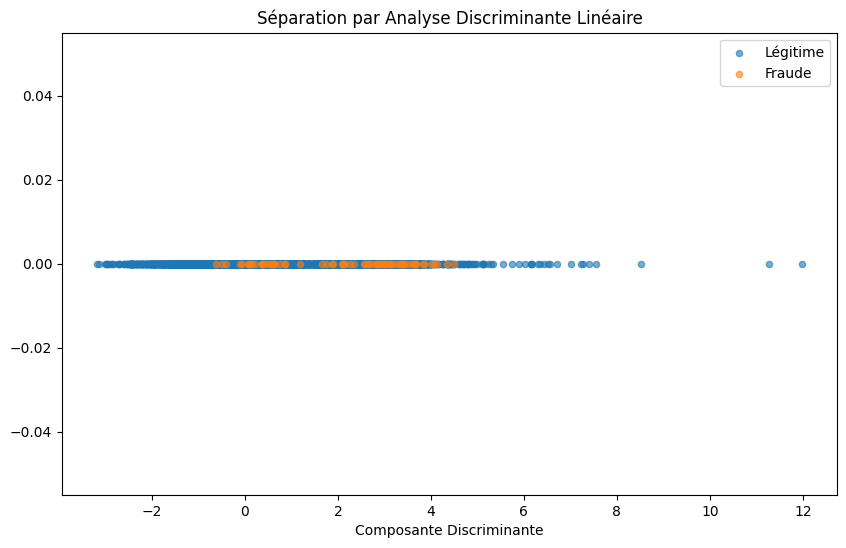

Top 10 des features les plus discriminantes:
                        feature  coefficient
13  use_chip_Online Transaction     1.605992
4       mcc_description_encoded    -0.950080
0                        amount     0.700997
14   use_chip_Swipe Transaction    -0.627021
12    use_chip_Chip Transaction    -0.419604
11    card_type_Debit (Prepaid)     0.259289
2         merchant_city_encoded     0.202626
1                  credit_limit    -0.192776
5               card_brand_Amex     0.134194
3        merchant_state_encoded    -0.118203


In [ ]:
# Analyse discriminante linéaire
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix

print("\n=== ANALYSE DISCRIMINANTE LINÉAIRE ===")

# LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(Xs, y)

# Visualisation LDA
plt.figure(figsize=(10, 6))
for label in [0, 1]:
    indices = y == label
    plt.scatter(X_lda[indices], np.zeros_like(X_lda[indices]), 
                label=f'{"Fraude" if label == 1 else "Légitime"}', 
                alpha=0.6, s=20)
plt.title('Séparation par Analyse Discriminante Linéaire')
plt.xlabel('Composante Discriminante')
plt.legend()
plt.show()

# Importance des features dans la discrimination
feature_importance = pd.DataFrame({
    'feature': features[:len(lda.coef_[0])],  # Prendre seulement le nombre de features correspondant
    'coefficient': lda.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Top 10 des features les plus discriminantes:")
print(feature_importance.head(10))

In [72]:
# Mesure de la séparabilité des clusters
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print("\n=== MESURE DE LA SÉPARABILITÉ ===")

methods = {
    'PCA': X_pca_3d,
    't-SNE': X_tsne_3d, 
    'UMAP': X_umap_3d
}

for name, data in methods.items():
    if len(data) > 1:
        silhouette = silhouette_score(data, y)
        calinski = calinski_harabasz_score(data, y)
        print(f"{name}:")
        print(f"  Score de silhouette: {silhouette:.4f}")
        print(f"  Score de Calinski-Harabasz: {calinski:.4f}")


=== MESURE DE LA SÉPARABILITÉ ===
PCA:
  Score de silhouette: 0.1121
  Score de Calinski-Harabasz: 44.6040
t-SNE:
  Score de silhouette: 0.0001
  Score de Calinski-Harabasz: 27.9218
UMAP:
  Score de silhouette: 0.0836
  Score de Calinski-Harabasz: 20.5766
